# CFP Composite Rankings

This notebook combines resume and predictive rankings with strength metrics to generate final composite rankings.

## Ranking Components

- **Resume (50%)**: What teams have accomplished (Colley + Win%)
- **Predictive (30%)**: Team strength/ability (Massey + Elo)
- **SOR (10%)**: Strength of Record (schedule-adjusted wins)
- **SOS (10%)**: Strength of Schedule (opponent quality)

## Conference Adjustment

Power 5 teams receive a 3% boost, Group of 5 teams receive a 3% penalty to account for historical CFP committee preferences.

## Tie-Breaker Protocol

1. Head-to-head result
2. Common opponents record
3. SOS rank
4. SOR rank
5. Composite score

In [1]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import warnings
import sys
import os
warnings.filterwarnings('ignore')

# Add notebooks directory to path for notebook_utils
notebook_dir = Path.cwd()
if notebook_dir.name != 'notebooks':
    notebook_dir = notebook_dir / 'notebooks'
if str(notebook_dir) not in sys.path:
    sys.path.insert(0, str(notebook_dir))

# Add project root to path for src imports
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from notebook_utils import (
    setup_notebook_env,
    load_cached_games,
    create_output_dirs,
    print_ranking_summary,
    validate_config
)

setup_notebook_env()

from src.utils.metrics import calculate_sor, calculate_sos
from src.utils.conference import apply_conference_adjustment, get_conference_tier
from src.playoff.bracket import apply_tiebreaker

# Configuration
year = 2025
week = 15

# Validate configuration
is_valid, error_msg = validate_config(year, week)
if not is_valid:
    raise ValueError(error_msg)

# Create output directories
output_dirs = create_output_dirs()
rankings_dir = output_dirs['rankings']
viz_dir = output_dirs['visualizations']

print(f'\n✅ Configuration: {year} Season, Week {week}')
print(f'✅ Output directory: {rankings_dir}')


✅ Configuration: 2025 Season, Week 15
✅ Output directory: data/output/rankings


In [2]:
# Load Component Rankings and Games Data

# Load individual ranking components
predictive_rankings = pd.read_csv(rankings_dir / f'predictive_rankings_{year}_week{week}.csv')
colley_rankings = pd.read_csv(rankings_dir / f'colley_rankings_{year}_week{week}.csv')
win_pct_rankings = pd.read_csv(rankings_dir / f'win_pct_rankings_{year}_week{week}.csv')

# Load games data
games_df = load_cached_games(year, week)

print(f'✅ Loaded {len(colley_rankings)} teams from component rankings')
print(f'✅ Loaded {len(games_df)} games')
print(f'\nComponent Rankings Available:')
print(f'  - Colley Matrix (resume)')
print(f'  - Win Percentage (resume)')
print(f'  - Massey + Elo (predictive)')

✅ Loaded 136 teams from component rankings
✅ Loaded 752 games

Component Rankings Available:
  - Colley Matrix (resume)
  - Win Percentage (resume)
  - Massey + Elo (predictive)


In [3]:
# Calculate SOR (Strength of Record)

def calculate_team_sor(team, games_df, power_ratings_dict, baseline_rating=0.75, rating_scale=0.25):
    """Calculate SOR: Probability average Top-25 team matches this record against this schedule."""
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    
    wins = 0
    losses = 0
    opponent_ratings = []
    
    for _, game in team_games.iterrows():
        if game['home_team'] == team:
            opponent = game['away_team']
            won = game['home_score'] > game['away_score']
        else:
            opponent = game['home_team']
            won = game['away_score'] > game['home_score']
        
        if won:
            wins += 1
        else:
            losses += 1
        
        opp_rating = power_ratings_dict.get(opponent, 0.5)
        opponent_ratings.append(opp_rating)
    
    team_record = {'wins': wins, 'losses': losses}
    
    return calculate_sor(
        team_record=team_record,
        opponent_ratings=opponent_ratings,
        baseline_rating=baseline_rating,
        rating_scale=rating_scale
    )

# Normalize predictive scores for opponent ratings
scaler = MinMaxScaler()
predictive_rankings['normalized_predictive'] = scaler.fit_transform(
    predictive_rankings[['predictive_score']]
)
power_ratings_dict = dict(zip(
    predictive_rankings['team'],
    predictive_rankings['normalized_predictive']
))

# Calculate SOR for all teams
sor_scores = {}
for team in colley_rankings['team']:
    sor_scores[team] = calculate_team_sor(team, games_df, power_ratings_dict)

print(f'✅ Calculated SOR for {len(sor_scores)} teams')
print(f'\nTop 5 SOR Scores (higher = harder schedule achievement):')
top_sor = sorted(sor_scores.items(), key=lambda x: x[1], reverse=True)[:5]
for team, score in top_sor:
    print(f'  {team}: {score:.4f}')

✅ Calculated SOR for 136 teams

Top 5 SOR Scores (higher = harder schedule achievement):
  Indiana: 1.3045
  Ohio State: 1.1105
  BYU: 0.9398
  Oregon: 0.8235
  Texas A&M: 0.6852


In [4]:
# Calculate SOS (Strength of Schedule)

def calculate_team_sos(team, games_df, include_oor=True, oor_weight=0.33):
    """Calculate SOS with opponent's opponents to prevent schedule inflation."""
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    
    opponents = []
    for _, game in team_games.iterrows():
        opponent = game['away_team'] if game['home_team'] == team else game['home_team']
        opponents.append(opponent)
    
    opponents_records = []
    opponents_opp_records = []
    
    for opp in opponents:
        opp_games = games_df[(games_df['home_team'] == opp) | (games_df['away_team'] == opp)]
        
        opp_wins = 0
        opp_losses = 0
        
        # Get opponent's record excluding game against this team
        for _, g in opp_games.iterrows():
            if (g['home_team'] == team and g['away_team'] == opp) or \
               (g['home_team'] == opp and g['away_team'] == team):
                continue
            
            if g['home_team'] == opp:
                if g['home_score'] > g['away_score']:
                    opp_wins += 1
                else:
                    opp_losses += 1
            else:
                if g['away_score'] > g['home_score']:
                    opp_wins += 1
                else:
                    opp_losses += 1
        
        opponents_records.append((opp_wins, opp_losses))
        
        # Get opponent's opponents' records
        opp_opp_records = []
        for _, g in opp_games.iterrows():
            opp_opp = g['away_team'] if g['home_team'] == opp else g['home_team']
            
            if opp_opp == team:
                continue
            
            opp_opp_games = games_df[
                (games_df['home_team'] == opp_opp) | (games_df['away_team'] == opp_opp)
            ]
            
            opp_opp_wins = 0
            opp_opp_losses = 0
            
            for _, gg in opp_opp_games.iterrows():
                if gg['home_team'] == opp_opp:
                    if gg['home_score'] > gg['away_score']:
                        opp_opp_wins += 1
                    else:
                        opp_opp_losses += 1
                else:
                    if gg['away_score'] > gg['home_score']:
                        opp_opp_wins += 1
                    else:
                        opp_opp_losses += 1
            
            opp_opp_records.append((opp_opp_wins, opp_opp_losses))
        
        opponents_opp_records.append(opp_opp_records)
    
    return calculate_sos(
        opponents_records=opponents_records,
        opponents_opp_records=opponents_opp_records,
        include_oor=include_oor,
        oor_weight=oor_weight
    )

# Calculate SOS for all teams
sos_scores = {}
for team in colley_rankings['team']:
    sos_scores[team] = calculate_team_sos(team, games_df, include_oor=True, oor_weight=0.33)

print(f'✅ Calculated SOS for {len(sos_scores)} teams')
print(f'\nTop 5 SOS Scores (higher = tougher schedule):')
top_sos = sorted(sos_scores.items(), key=lambda x: x[1], reverse=True)[:5]
for team, score in top_sos:
    print(f'  {team}: {score:.4f}')

✅ Calculated SOS for 136 teams

Top 5 SOS Scores (higher = tougher schedule):
  Florida: 0.6185
  Wisconsin: 0.6171
  Purdue: 0.6070
  South Carolina: 0.5990
  UCLA: 0.5947


In [5]:
# Merge All Components and Calculate Composite Score

# Rebuild resume rankings from components
resume_data = colley_rankings.merge(
    win_pct_rankings[['team', 'wins', 'losses', 'win_pct']],
    on='team'
)

# Calculate resume score (60% Colley, 40% Win%)
scaler_resume = MinMaxScaler()
resume_data['colley_norm'] = scaler_resume.fit_transform(resume_data[['colley_rating']])
resume_data['win_pct_norm'] = resume_data['win_pct']

resume_data['resume_score'] = (
    0.60 * resume_data['colley_norm'] +
    0.40 * resume_data['win_pct_norm']
)

# Build composite DataFrame
composite_df = resume_data[['team', 'wins', 'losses', 'resume_score']].copy()

composite_df = composite_df.merge(
    predictive_rankings[['team', 'predictive_score']],
    on='team',
    how='inner'
)

composite_df['sor'] = composite_df['team'].map(sor_scores)
composite_df['sos'] = composite_df['team'].map(sos_scores)

# Extract conference information from games
team_conferences = {}
for _, game in games_df.iterrows():
    if pd.notna(game.get('home_conference')):
        team_conferences[game['home_team']] = game['home_conference']
    if pd.notna(game.get('away_conference')):
        team_conferences[game['away_team']] = game['away_conference']

composite_df['conference'] = composite_df['team'].map(team_conferences)
composite_df['conference'] = composite_df['conference'].fillna('Independent')
composite_df['conf_tier'] = composite_df['conference'].apply(get_conference_tier)

# Normalize all components to 0-1 scale
scaler = MinMaxScaler()
composite_df['resume_norm'] = scaler.fit_transform(composite_df[['resume_score']])
composite_df['predictive_norm'] = scaler.fit_transform(composite_df[['predictive_score']])
composite_df['sor_norm'] = scaler.fit_transform(composite_df[['sor']])
composite_df['sos_norm'] = scaler.fit_transform(composite_df[['sos']])

# UPDATED WEIGHTS: More emphasis on resume to match CFP priorities
weights = {
    'resume': 0.50,      # Increased from 0.30
    'predictive': 0.30,  # Decreased from 0.40
    'sor': 0.10,         # Decreased from 0.15
    'sos': 0.10          # Decreased from 0.15
}

# Calculate base composite score
composite_df['composite_base'] = (
    weights['resume'] * composite_df['resume_norm'] +
    weights['predictive'] * composite_df['predictive_norm'] +
    weights['sor'] * composite_df['sor_norm'] +
    weights['sos'] * composite_df['sos_norm']
)

# Apply conference adjustments
composite_df['composite_score'] = composite_df.apply(
    lambda row: apply_conference_adjustment(
        team_score=row['composite_base'],
        conference=row['conference'],
        games_df=games_df,
        p5_boost=1.03,   # 3% boost for P5
        g5_penalty=0.97  # 3% penalty for G5
    ),
    axis=1
)

# Sort and rank
composite_df = composite_df.sort_values('composite_score', ascending=False).reset_index(drop=True)
composite_df['rank'] = range(1, len(composite_df) + 1)

print(f'✅ Merged all components for {len(composite_df)} teams')
print(f'\nWeighting Configuration:')
print(f'  Resume:     {weights["resume"]:.0%} (Colley + Win%)')
print(f'  Predictive: {weights["predictive"]:.0%} (Massey + Elo)')
print(f'  SOR:        {weights["sor"]:.0%}')
print(f'  SOS:        {weights["sos"]:.0%}')
print(f'\nConference Adjustments:')
print(f'  Power 5:    +3% boost')
print(f'  Group of 5: -3% penalty')

✅ Merged all components for 136 teams

Weighting Configuration:
  Resume:     50% (Colley + Win%)
  Predictive: 30% (Massey + Elo)
  SOR:        10%
  SOS:        10%

Conference Adjustments:
  Power 5:    +3% boost
  Group of 5: -3% penalty


In [6]:
# Display Top 25 Rankings with Conference Tiers

print('=' * 100)
print('TOP 25 COMPOSITE RANKINGS'.center(100))
print('=' * 100)
print()

display_df = composite_df[[
    'rank', 'team', 'wins', 'losses', 'conference', 'conf_tier',
    'resume_score', 'predictive_score', 'sor', 'sos', 'composite_score'
]].head(25)

print(display_df.to_string(index=False))
print()
print(f'P5 teams in top 25: {(display_df["conf_tier"] == "P5").sum()}')
print(f'G5 teams in top 25: {(display_df["conf_tier"] == "G5").sum()}')
print(f'Independent teams in top 25: {(display_df["conf_tier"] == "IND").sum()}')

                                     TOP 25 COMPOSITE RANKINGS                                      

 rank          team  wins  losses        conference conf_tier  resume_score  predictive_score      sor      sos  composite_score
    1    Ohio State    11       0           Big Ten        P5      1.000000          1.000000 1.110506 0.531169         0.976192
    2       Indiana    11       0           Big Ten        P5      0.990270          0.951107 1.304503 0.521527         0.967141
    3           BYU    10       1            Big 12        P5      0.932528          0.839702 0.939796 0.564098         0.892947
    4        Oregon    10       1           Big Ten        P5      0.909848          0.886623 0.823492 0.513665         0.864353
    5    Texas Tech    10       1            Big 12        P5      0.883488          0.983603 0.567335 0.488550         0.849449
    6       Georgia    10       1               SEC        P5      0.918998          0.829465 0.632303 0.531523         0.84

In [7]:
# Add Component Ranks for Analysis

composite_df['resume_rank'] = composite_df['resume_score'].rank(method='min', ascending=False).astype(int)
composite_df['predictive_rank'] = composite_df['predictive_score'].rank(method='min', ascending=False).astype(int)
composite_df['sor_rank'] = composite_df['sor'].rank(method='min', ascending=False).astype(int)
composite_df['sos_rank'] = composite_df['sos'].rank(method='min', ascending=False).astype(int)

print('Component Rankings Analysis (Top 15):')
print()
print(composite_df[[
    'rank', 'team', 'conf_tier',
    'resume_rank', 'predictive_rank', 'sor_rank', 'sos_rank'
]].head(15).to_string(index=False))
print()
print('Legend: Lower rank number = better in that component')

Component Rankings Analysis (Top 15):

 rank       team conf_tier  resume_rank  predictive_rank  sor_rank  sos_rank
    1 Ohio State        P5            1                1         2        35
    2    Indiana        P5            2                3         1        48
    3        BYU        P5            3                8         3        15
    4     Oregon        P5            5                5         4        60
    5 Texas Tech        P5            8                2         8        81
    6    Georgia        P5            4                9         6        34
    7  Texas A&M        P5            6               13         5        65
    8   Ole Miss        P5            7               16         7        67
    9   Oklahoma        P5           10               20         9        10
   10 Notre Dame       IND           12                4        11        49
   11    Alabama        P5           11               14        10        21
   12      Miami        P5           

In [8]:
# Export Final Rankings

final_rankings = composite_df[[
    'rank', 'team', 'wins', 'losses', 'conference', 'conf_tier',
    'resume_score', 'resume_rank',
    'predictive_score', 'predictive_rank',
    'sor', 'sor_rank',
    'sos', 'sos_rank',
    'composite_score'
]].copy()

# Save to rankings directory
csv_path = rankings_dir / f'composite_rankings_{year}_week{week}.csv'
final_rankings.to_csv(csv_path, index=False)

# Save to root for backward compatibility
final_rankings.to_csv('./final_rankings.csv', index=False)

print('✅ Final rankings exported:')
print(f'   {csv_path}')
print(f'   ./final_rankings.csv (for backward compatibility)')
print(f'\n📊 Total teams ranked: {len(final_rankings)}')

✅ Final rankings exported:
   data/output/rankings/composite_rankings_2025_week15.csv
   ./final_rankings.csv (for backward compatibility)

📊 Total teams ranked: 136


In [9]:
# Diagnostic: Conference Distribution in Top 25

top25 = composite_df.head(25)

print('=' * 80)
print('DIAGNOSTIC: Top 25 Conference Distribution')
print('=' * 80)
print()

conf_counts = top25['conference'].value_counts()
print('By Conference:')
for conf, count in conf_counts.items():
    tier = get_conference_tier(conf)
    print(f'  {conf} ({tier}): {count} teams')

print()
tier_counts = top25['conf_tier'].value_counts()
print('By Tier:')
for tier, count in tier_counts.items():
    print(f'  {tier}: {count} teams ({count/25*100:.1f}%)')

DIAGNOSTIC: Top 25 Conference Distribution

By Conference:
  Big Ten (P5): 7 teams
  SEC (P5): 7 teams
  Big 12 (P5): 4 teams
  American Athletic (G5): 3 teams
  ACC (P5): 2 teams
  FBS Independents (IND): 1 teams
  Sun Belt (G5): 1 teams

By Tier:
  P5: 20 teams (80.0%)
  G5: 4 teams (16.0%)
  IND: 1 teams (4.0%)



✅ Visualization saved: data/output/visualizations/composite_analysis_2025_week15.png


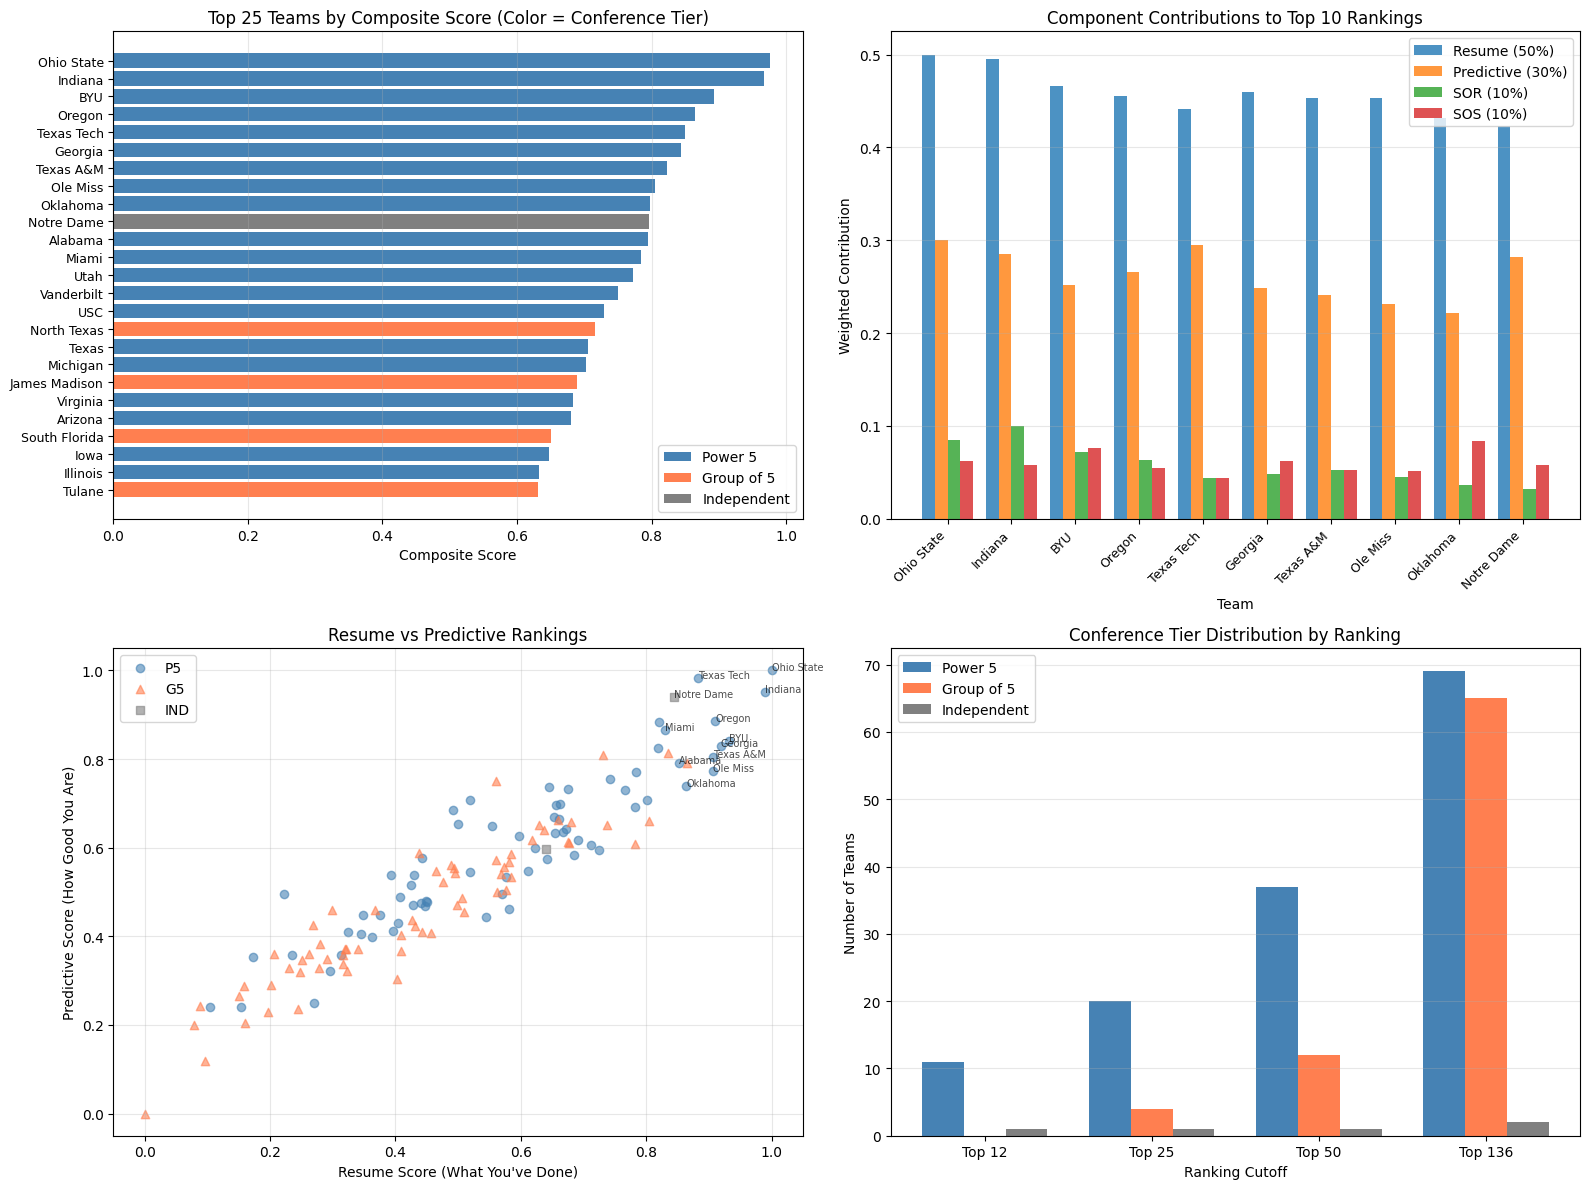

In [10]:
# Visualization: Component Contributions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 25 composite scores
ax1 = axes[0, 0]
top25 = final_rankings.head(25)
colors = top25['conf_tier'].map({'P5': 'steelblue', 'G5': 'coral', 'IND': 'gray'})
ax1.barh(range(25, 0, -1), top25['composite_score'], color=colors)
ax1.set_yticks(range(25, 0, -1))
ax1.set_yticklabels(top25['team'], fontsize=9)
ax1.set_xlabel('Composite Score')
ax1.set_title('Top 25 Teams by Composite Score (Color = Conference Tier)')
ax1.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', label='Power 5'),
    Patch(facecolor='coral', label='Group of 5'),
    Patch(facecolor='gray', label='Independent')
]
ax1.legend(handles=legend_elements, loc='lower right')

# Plot 2: Component contributions for top 10
ax2 = axes[0, 1]
top10 = composite_df.head(10)
x = np.arange(10)
width = 0.2

ax2.bar(x - 1.5*width, top10['resume_norm'] * weights['resume'], width, 
        label=f'Resume ({weights["resume"]:.0%})', alpha=0.8)
ax2.bar(x - 0.5*width, top10['predictive_norm'] * weights['predictive'], width, 
        label=f'Predictive ({weights["predictive"]:.0%})', alpha=0.8)
ax2.bar(x + 0.5*width, top10['sor_norm'] * weights['sor'], width, 
        label=f'SOR ({weights["sor"]:.0%})', alpha=0.8)
ax2.bar(x + 1.5*width, top10['sos_norm'] * weights['sos'], width, 
        label=f'SOS ({weights["sos"]:.0%})', alpha=0.8)

ax2.set_xlabel('Team')
ax2.set_xticks(x)
ax2.set_xticklabels(top10['team'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Weighted Contribution')
ax2.set_title('Component Contributions to Top 10 Rankings')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Resume vs Predictive scatter
ax3 = axes[1, 0]
for tier, color, marker in [('P5', 'steelblue', 'o'), ('G5', 'coral', '^'), ('IND', 'gray', 's')]:
    tier_teams = composite_df[composite_df['conf_tier'] == tier]
    ax3.scatter(tier_teams['resume_score'], tier_teams['predictive_score'], 
               c=color, marker=marker, label=tier, alpha=0.6)

for i, row in composite_df.head(12).iterrows():
    ax3.annotate(row['team'], (row['resume_score'], row['predictive_score']), 
                fontsize=7, alpha=0.7)

ax3.set_xlabel('Resume Score (What You\'ve Done)')
ax3.set_ylabel('Predictive Score (How Good You Are)')
ax3.set_title('Resume vs Predictive Rankings')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Conference tier distribution
ax4 = axes[1, 1]
tier_dist = []
for cutoff in [12, 25, 50, len(composite_df)]:
    top_n = composite_df.head(cutoff)
    tier_dist.append({
        'Top': f'Top {cutoff}',
        'P5': (top_n['conf_tier'] == 'P5').sum(),
        'G5': (top_n['conf_tier'] == 'G5').sum(),
        'IND': (top_n['conf_tier'] == 'IND').sum()
    })

dist_df = pd.DataFrame(tier_dist)
x_pos = np.arange(len(dist_df))
width = 0.25

ax4.bar(x_pos - width, dist_df['P5'], width, label='Power 5', color='steelblue')
ax4.bar(x_pos, dist_df['G5'], width, label='Group of 5', color='coral')
ax4.bar(x_pos + width, dist_df['IND'], width, label='Independent', color='gray')

ax4.set_xlabel('Ranking Cutoff')
ax4.set_ylabel('Number of Teams')
ax4.set_title('Conference Tier Distribution by Ranking')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(dist_df['Top'])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
viz_path = viz_dir / f'composite_analysis_{year}_week{week}.png'
plt.savefig(viz_path, dpi=150, bbox_inches='tight')
print(f'\n✅ Visualization saved: {viz_path}')
plt.show()

---

## Summary

Composite rankings complete with conference-aware adjustments.

**Next Steps:**
- `04_resume_analysis.ipynb` - Detailed team resume sheets
- `05_playoff_selection.ipynb` - 12-team bracket selection
- `08_validation_backtesting.ipynb` - Validate against historical CFP rankings